### Initial Configuration

In [1]:
# Set logging
import logging

logging.basicConfig(level=logging.DEBUG)

# Set the GPU_ENABLED Flag to True
import os
os.environ['GPU_ENABLED'] = 'True'
print(os.environ['GPU_ENABLED'])  # Should print 'True'

True


### Load a Story

In [2]:
from story_wrapper.models.story import Story
from story_wrapper.data_loaders.gutenberg import Gutenberg
from story_wrapper.config_spacy import nlp_service

In [3]:
g_corpus = Gutenberg()
book = g_corpus.get_book_object(13034)

INFO:root:Indexing Gutenberg corpus.
INFO:root:Reading metadata from /home/ben/Projects/story-wrapper/src/story_wrapper/data_loaders/indexes/md.pickle.gz
INFO:root:Indexing complete.
INFO:root:Number of books in Gutenberg corpus: 69478
 at line 8197 line: End of Project Gutenberg's Mary Minds Her Business, by George Weston
DEBUG:root:TOC locations to be deleted: []
INFO:root:Heading locations: [292, 408, 512, 625, 942, 1108, 1255, 1343, 1434, 1643, 1896, 2151, 2367, 2539, 2676, 2937, 3082, 3212, 3416, 3516, 3717, 4010, 4140, 4388, 4616, 5364, 5534, 6361, 6419, 6807, 6973, 7201, 7349, 7670, 7815, 7980, 8086, 8197]
INFO:root:Headings: ['CHAPTER I\r', 'CHAPTER II\r', 'CHAPTER III\r', 'CHAPTER IV\r', 'CHAPTER V\r', 'CHAPTER VI\r', 'CHAPTER VII\r', 'CHAPTER VIII\r', 'CHAPTER IX\r', 'CHAPTER X\r', 'CHAPTER XI\r', 'CHAPTER XII\r', 'CHAPTER XIII\r', 'CHAPTER XIV\r', 'CHAPTER XV\r', 'CHAPTER XVI\r', 'CHAPTER XVII\r', 'CHAPTER XVIII\r', 'CHAPTER XIX\r', 'CHAPTER XX\r', 'CHAPTER XXI\r', 'CHAPTER 

In [4]:
story = Story(book.paragraphs)

INFO:root:Loading Spacy Model en_core_web_trf
INFO:root:GPU Enabled: True - Using GPU
/home/ben/Projects/story-wrapper/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
DEBUG:root:Configuring NLP Pipeline and Custom Properties


## Characters

In [5]:
story.people_list()

['Patty',
 'Cordelia',
 'Josiah',
 'Patricia',
 'Cordelia',
 'Spencers',
 'Cordelia',
 'Cordelia',
 'Spencer',
 'Cordelia',
 'Patty',
 'Josiah',
 'Spicers',
 'Abner Spicer',
 'an Ezra Babcock',
 'Josiah Spencer',
 'Josiah',
 'Cordelia',
 'Patty',
 'Josiah',
 'Cordelia',
 'Pearsons',
 'Martha Berger',
 'Pearsons',
 'Cordelia',
 'Patty',
 'Martha',
 'Cordelia',
 'Martha',
 'Patty',
 'Cordelia',
 'Martha',
 'Josiah',
 'Martha',
 'Martha',
 'Cordelia',
 'Martha',
 'Spencers',
 'Cordelia',
 'Josiah',
 'Abner Spencer',
 'Ezra Babcock',
 'Josiah Spencer',
 'Cordelia',
 'Patty',
 'Spencer',
 'Josiah',
 'Josiah',
 'Josiah',
 'Spencer',
 'Martha',
 'Cordelia',
 'Patty',
 'Josiah',
 'Patty',
 'Sarah',
 'Sarah',
 'Martha',
 'Martha',
 'Cordelia',
 'Martha',
 'Patty',
 'Cordelia',
 'Martha',
 'Patty',
 'Martha',
 'Cordelia',
 'Barbara Fritchie',
 'Patrick Henry',
 'Josiah',
 'Cordelia',
 'Patty',
 'Cordelia',
 'Patty',
 'Patty',
 'Cordelia',
 'Cordelia',
 'Patty',
 'Josiah',
 'Cordelia',
 'Basil',


In [6]:
len(story.occurrences), len(story.people_list())

(1711, 1711)

We can maybe think about processing serially.

As we run through we can build a set of ent strings. These are candidates.

When we hit a name there are several options:
* It's a new character;
* It's a match for a previous character.

Your high-level plan sounds well-structured. Here's a more detailed breakdown of the coding steps, building on your ideas:

### Phase 1: Initial Setup
1. **Generate Occurrences**: Process the text with spaCy to get all `ent` spans, and then create `Occurrence` objects for each one of these.
2. **Initial Character Candidate Set**: Create an initial set of `Character` objects based on the unique cleaned `text` properties of the `Occurrence` objects. This will involve text cleaning like removing determiners and trailing "s".

### Phase 2: Multiple Token Matches
1. **Identify Multiple Token Candidates**: Filter the initial set of `Character` objects to only include names that are multiple tokens. 
2. **Fuzzy Matching**: For each multiple-token `Character`, create a list of potential matches from the `Occurrence` objects. This could be done through partial token matching, lemmatization, or other techniques.
3. **Unambiguous Matches**: If the list from the previous step contains only one entry, associate all corresponding `Occurrence` objects with that `Character`.
4. **Character Merging**: For multiple-token names that are unambiguously matched, consider merging them into a single `Character` if needed. For example, "John Doe" and "Mr. John Doe" could potentially be merged.
5. **Surnames and Titles**: At this stage, you could also collect all unique surnames and titles for use in later phases.

### Phase 3: Single Token Matches
1. **Identify Single Token Candidates**: Now focus on the single-token names from the `Character` objects.
2. **Associate with Multiple-Token Matches**: Using the multiple-token matches as a reference, assign single-token `Occurrence` objects to corresponding `Character` objects where possible. For instance, "John" could be mapped to "John Doe" if "John Doe" has already been identified.
3. **Disambiguation and Context**: Apply additional logic, potentially involving contextual information, to disambiguate single-token names that match with multiple `Character` objects.

### Phase 4: Refinement and Output
1. **Apply Nickname Logic**: Incorporate your nickname dictionary to further refine the matches.
2. **Generate Output**: Create a final list of `Character` objects, each enriched with its associated `Occurrence` objects, relationships, and other metadata.

This can be an iterative process. After an initial pass, you might find it useful to return to earlier steps to refine the character matches using newly-acquired context.

Would you like to proceed to code some parts of this plan, or should we discuss this further?

In [13]:
multiple_token_candidates = story.get_multiple_token_candidates(); print(multiple_token_candidates)

['abner spicer', 'ezra babcock', 'josiah spencer', 'martha berger', 'abner spencer', 'barbara fritchie', 'patrick henry', 'angel of death', 'angel of life', 'dauphin of', 'stanley woodward', 'cousin stanley', 'archey forbes', 'bob mcallister', 'mon dieu', 'st. cecilia', 'wally cabot', 'walter cabot', 'will thompson', 'george washington', 'mary spencer', 'm. spencer', 'uncle stanley', 'burdon woodward', 'david copperfield', 'black jack', 'betsey ross', 'joan of arc', "ma'm maynard", 'james o. macpherson', 'josiah spencers', "m'sieur beaucaire", 'don juan', 'lieutenant cabot', 'molly pitcher', 'jimmy kelly', 'mary mcmillan', 'james kelly', 'sam reisinger', 'helen cabot', 'nicholas rapieff', 'paul spencer', 'archibald forbes', 'william the thoughtful']


In [8]:
occurrences_by_text = story.get_occurrences_by_text()

In [9]:
potential_first_names, potential_surnames = story.populate_name_candidates()

In [10]:
print(potential_first_names, "\n\n", potential_surnames)

{'josiah', 'm.', 'angel', 'mon', 'burdon', 'george', 'bob', 'sam', 'james', 'jimmy', 'walter', 'st.', 'archey', 'betsey', 'joan', 'uncle', 'don', 'barbara', 'helen', 'paul', "m'sieur", 'lieutenant', 'abner', 'martha', 'cousin', 'nicholas', 'patrick', "ma'm", 'will', 'black', 'archibald', 'mary', 'william', 'wally', 'stanley', 'dauphin', 'david', 'ezra', 'molly'} 

 {'forbes', 'reisinger', 'beaucaire', 'mcallister', 'arc', 'kelly', 'berger', 'dieu', 'fritchie', 'death', 'babcock', 'cecilia', 'spencer', 'of', 'copperfield', 'woodward', 'life', 'macpherson', 'pitcher', 'thompson', 'mcmillan', 'henry', 'washington', 'spicer', 'juan', 'jack', 'cabot', 'rapieff', 'spencers', 'maynard', "spencer'--you", 'stanley', 'thoughtful', 'ross'}


In [15]:
from itertools import combinations

combinations_list = list(combinations(multiple_token_candidates, 2))

print(combinations_list)

[('abner spicer', 'ezra babcock'), ('abner spicer', 'josiah spencer'), ('abner spicer', 'martha berger'), ('abner spicer', 'abner spencer'), ('abner spicer', 'barbara fritchie'), ('abner spicer', 'patrick henry'), ('abner spicer', 'angel of death'), ('abner spicer', 'angel of life'), ('abner spicer', 'dauphin of'), ('abner spicer', 'stanley woodward'), ('abner spicer', 'cousin stanley'), ('abner spicer', 'archey forbes'), ('abner spicer', 'bob mcallister'), ('abner spicer', 'mon dieu'), ('abner spicer', 'st. cecilia'), ('abner spicer', 'wally cabot'), ('abner spicer', 'walter cabot'), ('abner spicer', 'will thompson'), ('abner spicer', 'george washington'), ('abner spicer', 'mary spencer'), ('abner spicer', 'm. spencer'), ('abner spicer', 'uncle stanley'), ('abner spicer', 'burdon woodward'), ('abner spicer', 'david copperfield'), ('abner spicer', 'black jack'), ('abner spicer', 'betsey ross'), ('abner spicer', 'joan of arc'), ('abner spicer', "ma'm maynard"), ('abner spicer', 'james o

In [28]:
from itertools import combinations
from story_wrapper.models import Occurrence

def filter_relevant_combinations(occurrences_by_text: dict, candidates: list) -> list:
    """
    Filter out combinations of candidates where no tokens match.
    
    Args:
    - occurrences_by_text (dict): The dictionary mapping occurrence texts to a list of Occurrence objects.
    - candidates (list): The list of candidate characters.
    
    Returns:
    - list: A filtered list of relevant combinations.
    """
    relevant_combinations = []
    excluded_pos = ["DET", "PART", "ADP"]
    
    # Generate all combinations of 2 candidates
    for candidate1, candidate2 in combinations(candidates, 2):
        span1 = occurrences_by_text[candidate1][0].span
        span2 = occurrences_by_text[candidate2][0].span
        
        tokens1 = {token.lower_ for token in span1 if token.pos_ not in excluded_pos}
        tokens2 = {token.lower_ for token in span2 if token.pos_ not in excluded_pos}
        
        # Check if there are any common tokens
        if tokens1.intersection(tokens2):
            relevant_combinations.append((candidate1, candidate2))
            
    return relevant_combinations

# Example

candidates = list(occurrences_by_text.keys())
filtered_combinations = filter_relevant_combinations(occurrences_by_text, candidates)

print(filtered_combinations)


[('josiah', 'josiah spencer'), ('josiah', 'josiah spencers'), ('spencers', 'josiah spencers'), ('spencer', 'josiah spencer'), ('spencer', 'abner spencer'), ('spencer', 'm. spencer'), ('spencer', 'paul spencer'), ('abner spicer', 'abner spencer'), ('abner spicer', 'spicer'), ('josiah spencer', 'abner spencer'), ('josiah spencer', 'm. spencer'), ('josiah spencer', 'josiah spencers'), ('josiah spencer', 'paul spencer'), ('martha berger', 'martha'), ('abner spencer', 'm. spencer'), ('abner spencer', 'paul spencer'), ('angel of death', 'angel of life'), ('mary', 'mary spencer'), ('mary', 'mary mcmillan'), ('maynard', "ma'm maynard"), ('woodward', 'stanley woodward'), ('woodward', 'burdon woodward'), ('stanley woodward', 'cousin stanley'), ('stanley woodward', 'stanley'), ('stanley woodward', 'uncle stanley'), ('stanley woodward', 'burdon woodward'), ('cousin stanley', 'stanley'), ('cousin stanley', 'uncle stanley'), ('stanley', 'uncle stanley'), ('burdon', 'burdon woodward'), ('archey forbe

So these combinations represent potential matches?

First we could look for where the number of tokens match and there is a match in nicknames for the first name.

In [ ]:
for candidate_1, candidate_2 in filtered_combinations:
    # We might want to use split here as span may still have "the", "of", and "'s'"
    tokens = candidate_1.split()
    tokens = candidate_2.split()
    

In [29]:
occurrences_by_text['abner spicer']

[<Occurrence - text index: 14; span: Abner Spicer>]

In [34]:
occurrences_by_text['abner spencer']

[<Occurrence - text index: 40; span: Abner Spencer>]

In [35]:
story.text[40]

'Almost speaking in concert they told him about Captain Abner Spencer who had children until he was sixty, and Ezra Babcock, father-in-law of the third Josiah Spencer, who had a son proudly born to him in his sixty-fourth year.'

In [31]:
story.text[14]

'"I wonder if Josiah--is too old--to marry again! Of course," she hurriedly added, "he is fifty-two--but it seems to me that one of the Spicers--I think it was Captain Abner Spicer--had children until he was sixty--although by a younger wife, of course."'

In [36]:
story.text[10:50]

['And so they sat looking at each other, intently, almost breathlessly, each suddenly moved by the same question and each wishing that the other would speak.',
 'For the second time it was Cordelia who broke the silence.',
 '"Patty--!"',
 '"Yes, dear?" breathed Patty, and left her lips slightly parted.',
 '"I wonder if Josiah--is too old--to marry again! Of course," she hurriedly added, "he is fifty-two--but it seems to me that one of the Spicers--I think it was Captain Abner Spicer--had children until he was sixty--although by a younger wife, of course."',
 'They looked it up and in so doing they came across an Ezra Babcock, father-in-law of the Third Josiah Spencer, who had had a son proudly born to him in his sixty-fourth year.',
 'They gazed at each other then, those two maiden sisters, like two conspirators in their precious innocence.',
 '"If we could find Josiah a young wife--" said the elder at last.',
 '"Oh, Cordelia!" breathed Patty, "if, indeed, we only could!"',
 'Which was

Looks like in this story "spicer" is a typo....

In [32]:
occurrences_by_text['spicer']

[<Occurrence - text index: 195; span: Spicer>,
 <Occurrence - text index: 310; span: Spicer>]

In [33]:
story.text[195], story.text[310]

('In looking up the genealogy of the Spicer family, Miss Patty discovered that a distant relative in Charleston had just died, leaving a daughter behind him--an orphan--who was a year older than Mary. Correspondence finally led Miss Patty to make the journey, and when she returned she brought with her a dark-eyed girl who might have been the very spirit of youthful romance.',
 'To college! A Spencer girl--or a Spicer--going to college! Miss Cordelia gasped. If Mary had been noticing, she might not have pursued her inspiration further, but her mind was running along a breathless panorama of Niagara Falls, Great Lakes, Chicago, the farms of the Middle West, Yellowstone Park, geysers, the Old Man of the Mountain, Aztec ruins, redwood forests, orange groves and at the end of the vista--like a statue at the end of a garden walk--she imagined a great democratic institution of learning where one might conceivably be prepared to solve some of those problems which life seems to take such deep d

In [21]:
for key, occurrences in occurrences_by_text.items():
    for o in occurrences:
        if "'s" in o.span.text:
            print(key)

wally cabot
burdon woodward
ma'm maynard
ma'm maynard
ma'm maynard
m'sieur beaucaire


In [25]:
for t in occurrences_by_text['wally cabot'][5].span:
    print(t.pos_)

PROPN
PROPN
PART


In [17]:
occurrences_by_text['william the thoughtful']

[<Occurrence - text index: 1769; span: William the Thoughtful>]

In [18]:
occurrences_by_text['angel of death']

[<Occurrence - text index: 80; span: the Angel of Death>]

In [19]:
occurrences_by_text['angel of death'][0].span[0].pos_

'DET'

In [27]:
occurrences_by_text['angel of death'][0].span[2].pos_

'ADP'

In [20]:
occurrences_by_text['william the thoughtful'][0].span[1].pos_

'DET'

In [37]:
filtered_2 = filter_relevant_combinations(occurrences_by_text, multiple_token_candidates); print(filtered_2)

[('abner spicer', 'abner spencer'), ('josiah spencer', 'abner spencer'), ('josiah spencer', 'm. spencer'), ('josiah spencer', 'josiah spencers'), ('josiah spencer', 'paul spencer'), ('abner spencer', 'm. spencer'), ('abner spencer', 'paul spencer'), ('angel of death', 'angel of life'), ('stanley woodward', 'cousin stanley'), ('stanley woodward', 'uncle stanley'), ('stanley woodward', 'burdon woodward'), ('cousin stanley', 'uncle stanley'), ('archey forbes', 'archibald forbes'), ('wally cabot', 'walter cabot'), ('wally cabot', 'lieutenant cabot'), ('wally cabot', 'helen cabot'), ('walter cabot', 'lieutenant cabot'), ('walter cabot', 'helen cabot'), ('mary spencer', 'mary mcmillan'), ('m. spencer', 'paul spencer'), ('james o. macpherson', 'james kelly'), ('lieutenant cabot', 'helen cabot'), ('jimmy kelly', 'james kelly')]


Do we create a Character candidate from every "multiple_token_candidates"?

They all look valid - for a few we need to merge but we can then work at the Character level.

In [40]:
from story_wrapper.models import Character

In [43]:
story.potential_characters = []
for candidate in multiple_token_candidates:
    new_character = Character()
    new_character.name = candidate
    new_character.add_occurrences(occurrences_by_text[candidate])
    splits = candidate.split()
    if len(splits) > 1:
        new_character.first_name = splits[0]
        new_character.surname = splits[-1]
        if len(splits) > 2:
            new_character.middle_names = splits[1:-1]
    story.potential_characters.append(new_character)

In [44]:
story.potential_characters

[<Character - ID: 8729713626971; name: abner spicer>,
 <Character - ID: 8729713626239; name: ezra babcock>,
 <Character - ID: 8729713627121; name: josiah spencer>,
 <Character - ID: 8729713626905; name: martha berger>,
 <Character - ID: 8729713627013; name: abner spencer>,
 <Character - ID: 8729713626923; name: barbara fritchie>,
 <Character - ID: 8729713627001; name: patrick henry>,
 <Character - ID: 8729713545724; name: angel of death>,
 <Character - ID: 8729713545703; name: angel of life>,
 <Character - ID: 8729713545580; name: dauphin of>,
 <Character - ID: 8729713545799; name: stanley woodward>,
 <Character - ID: 8729713545817; name: cousin stanley>,
 <Character - ID: 8729713545796; name: archey forbes>,
 <Character - ID: 8729713545754; name: bob mcallister>,
 <Character - ID: 8729713545544; name: mon dieu>,
 <Character - ID: 8729713545490; name: st. cecilia>,
 <Character - ID: 8729713545553; name: wally cabot>,
 <Character - ID: 8729713545571; name: walter cabot>,
 <Character - I

In [41]:
'james o. macpherson'.split()[1:-1]

['o.']

In [ ]:
for char in story.potential_characters

In [50]:
from itertools import combinations
from story_wrapper.models import Occurrence, Character

def filter_relevant_character_combinations(characters: list[Character]) -> list:
    """
    Filter out combinations of candidates where no tokens match.
    
    Args:
    - characters: a list of potential characters in the Character object form.
    
    Returns:
    - list: A filtered list of relevant combinations.
    """
    relevant_combinations = []
    excluded_pos = ["DET", "PART", "ADP"]
    
    # Generate all combinations of 2 candidates
    for candidate1, candidate2 in combinations(characters, 2):
        span1 = candidate1.occurrences[0].span
        span2 = candidate2.occurrences[0].span
        
        tokens1 = {token.lower_ for token in span1 if token.pos_ not in excluded_pos}
        tokens2 = {token.lower_ for token in span2 if token.pos_ not in excluded_pos}
        
        # Check if there are any common tokens
        if tokens1.intersection(tokens2):
            relevant_combinations.append((candidate1, candidate2))
            
    return relevant_combinations

# Example

filtered_character_combinations = filter_relevant_character_combinations(story.potential_characters)

for c1, c2 in filtered_character_combinations:
    print(c1.name, "<>", c2.name)

abner spicer <> abner spencer
josiah spencer <> abner spencer
josiah spencer <> m. spencer
josiah spencer <> josiah spencers
josiah spencer <> paul spencer
abner spencer <> m. spencer
abner spencer <> paul spencer
angel of death <> angel of life
stanley woodward <> cousin stanley
stanley woodward <> uncle stanley
stanley woodward <> burdon woodward
cousin stanley <> uncle stanley
archey forbes <> archibald forbes
wally cabot <> walter cabot
wally cabot <> lieutenant cabot
wally cabot <> helen cabot
walter cabot <> lieutenant cabot
walter cabot <> helen cabot
mary spencer <> mary mcmillan
m. spencer <> paul spencer
james o. macpherson <> james kelly
lieutenant cabot <> helen cabot
jimmy kelly <> james kelly


## Nicknames

https://github.com/carltonnorthern/nicknames

In [38]:
from nicknames import NickNamer

nn = NickNamer()

In [39]:
nn.nicknames_of("Walter")

{'wally', 'walt'}

In [51]:
nn.nicknames_of("archibald")

{'archie'}

In [48]:
for c1, c2 in filtered_character_combinations:
    if c2.first_name in nn.nicknames_of(c1.first_name) or c1.first_name in nn.nicknames_of(c2.first_name):
        print(f"Match {c1}, {c2}")

Match <Character - ID: 8729713545553; name: wally cabot>, <Character - ID: 8729713545571; name: walter cabot>
Match <Character - ID: 8729713448093; name: jimmy kelly>, <Character - ID: 8729713448120; name: james kelly>


We run a merge method, replace the character ID of the main character with the merged version and delete the character that has been merged in.

In [52]:
def merge_characters_by_alias(main_character: Character, character_to_merge: Character) -> Character:
    """Merge two characters and return merged Character object."""
    main_character.add_occurrences(character_to_merge.occurrences)
    main_character.aliases.append(character_to_merge.first_name)
    return main_character

In [54]:
characters = story.potential_characters
print(characters, "\n\n")
for candidate1, candidate2 in filtered_character_combinations:
    if candidate2.firstname in nn.nicknames_of(candidate1.firstname):
        merge_characters_by_alias(candidate1, candidate2)
        characters.remove(candidate2)
    if candidate1.firstname in nn.nicknames_of(candidate2.firstname):
        merge_characters_by_alias(candidate2, candidate1)
        characters.remove(candidate1)
story.potential_characters = characters
print(characters)

[<Character - ID: 8729713626971; name: abner spicer>, <Character - ID: 8729713626239; name: ezra babcock>, <Character - ID: 8729713627121; name: josiah spencer>, <Character - ID: 8729713626905; name: martha berger>, <Character - ID: 8729713627013; name: abner spencer>, <Character - ID: 8729713626923; name: barbara fritchie>, <Character - ID: 8729713627001; name: patrick henry>, <Character - ID: 8729713545724; name: angel of death>, <Character - ID: 8729713545703; name: angel of life>, <Character - ID: 8729713545580; name: dauphin of>, <Character - ID: 8729713545799; name: stanley woodward>, <Character - ID: 8729713545817; name: cousin stanley>, <Character - ID: 8729713545796; name: archey forbes>, <Character - ID: 8729713545754; name: bob mcallister>, <Character - ID: 8729713545544; name: mon dieu>, <Character - ID: 8729713545490; name: st. cecilia>, <Character - ID: 8729713545553; name: wally cabot>, <Character - ID: 8729713545571; name: walter cabot>, <Character - ID: 8729713545823; 

AttributeError: 'Character' object has no attribute 'aliases'

Would it be useful to have a candidate list of first names and a candidate list of last names?

We would need to use the multiple_token_candidates

In [ ]:
set(story.people_list())

In [ ]:
len(set(story.people_list()))

In [ ]:
len(set([o.text for o in story.occurrences]))

In [ ]:
len(set([o.text.lower() for o in story.occurrences]))

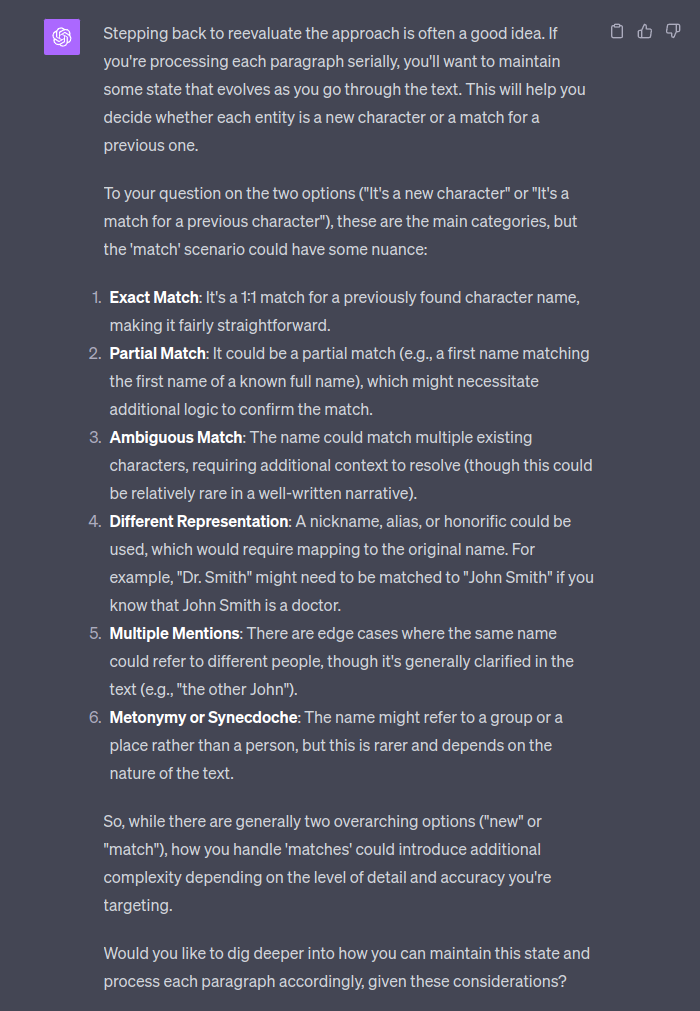

Do we iterate through the occurrences and add to a set any lower version? And also generate a Character as a candidate_character?

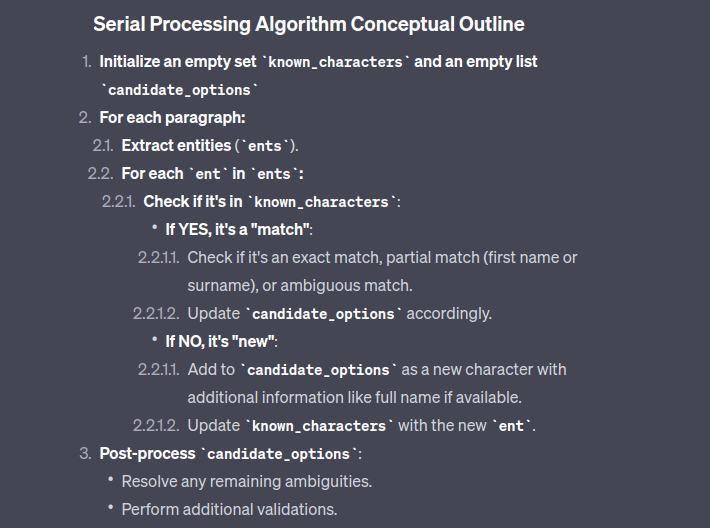

I also now have a dictionary of nicknames.

We want to flag if it is a match and save the match type:
* Exact Single One Token - exact string match with a character name that is one token and where we have only one character entry for that name (e.g., this would be a firstname or surname match - "Mary" and "Mary" or "Spencer" and "Spencer").
* Exact Single Multiple Token - exact string match with a character name that is multiple tokens and where we have only one character entry for that name (e.g., this would be a firstname and surname match). This would be the most reliable. E.g. "Mary Jones" and "Mary Jones".
* Partial - one or more but not all tokens match, e.g. "Mary" and "Mary Jones" (or vice versa). Or "Stanley" and "Cousin Stanley".
* Partial Mutliple Token - multiple tokens match but not all tokens, more reliable that just one partial token match (e.g., John Major and John O. Major)
* Partial Within String - probably the least reliable but sometimes a possessive "'s" does not have the "'" so we have "Ishmael" and "Ishmaels" - more reliable if single token and there is a match apart from the last "s"
* Exact Multiple/Ambiguous - exact string match but multiple characters with the same name, e.g. we have previous "Mary Jones" and "Mary Smith" and now we have "Mary".
* Nickname Exact Single One Token - a match via a nickname - the name is only one token and matches the character name as a nickname match (e.g. Patty and Patricia).
* Nickname and surname match Multiple Token - the surnames match and the first name has a nickname match. This is also pretty reliable. E.g. "Patricia Smith" and "Patty Smith".

In [ ]:
story.count_characters()

In [ ]:
"Mary".split()

In [ ]:
multiple_words = [c for c in story.characters() if len(c.split()) > 1]

In [ ]:
multiple_words

In [ ]:
character_names = story.characters()

In [ ]:
from collections import defaultdict

def (character_names: list) -> dict:
    """Build a dictionary of unique names."""
    name_dict = defaultdict(set)
    for name in character_names:
        name_parts = name.split()
        first_name = name_parts[0].lower()  # Normalizing to lowercase
        name_dict[first_name].add(name)
    return {k: list(v) for k, v in name_dict.items()}

unique_name_dict = build_unique_name_dict(character_names)
print(unique_name_dict)

In [ ]:
spacy_characters = []
for doc in story.docs:
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            spacy_characters.append(ent)

In [ ]:
spacy_characters

In [ ]:
spacy_characters[14][0], spacy_characters[14][0].pos_

In [ ]:
for char in spacy_characters:
    if char[0].pos_ == "DET":
        print(f"{char.text} has a leading DET. Name without: {char[1:].text}")

In [ ]:
from typing import List, Dict, Union
from spacy.tokens import Span

def clean_entities(spacy_characters: List[Span]) -> List[Dict[str, Union[str | Span]]]:
    """Clean and store SpaCy character entities."""
    cleaned_chars = []
    for char in spacy_characters:
        char_dict = {"original": char.text, "cleaned": char.text, "ent_span": char}

        # Remove leading determiners
        if char[0].pos_ == "DET":
            char_dict["cleaned"] = char[1:].text

        # Remove trailing possessives
        if char[-1].text == "'s" or char[-1].text == "’s":
            char_dict["cleaned"] = char[:-1].text
            
        

        cleaned_chars.append(char_dict)
    return cleaned_chars

In [ ]:
cleaned = clean_entities(spacy_characters)

In [ ]:
cleaned

In [ ]:
unique = build_unique_name_dict([c['cleaned'] for c in cleaned])

In [ ]:
unique['burdon']

In [ ]:
burdon = [c for c in cleaned if c['cleaned'] == 'Burdon Woodward--']

In [ ]:
burdon

In [ ]:
len(burdon[0]['ent_span'])

In [ ]:
burdon[0]['ent_span'][-1]

In [ ]:
unique

In [ ]:
def find_single_reference_names(name_dict: Dict[str, List[str]]) -> Dict[str, str]:
    """
    Identify names that only appear with one full-name configuration.
    Modified to handle edge cases.
    """
    single_reference_names = {}
    for first_name, full_names in name_dict.items():
        # Normalize case
        full_names = [name.lower() for name in full_names]
        
        # Filter out polluted names and single first names
        clean_full_names = [name for name in full_names if name.isalpha() and name != first_name]
        
        # If there's only one unique full name, consider it a single reference name
        if len(set(clean_full_names)) == 1:
            single_reference_names[first_name] = clean_full_names[0]
            
    return single_reference_names

# Example usage
name_dict = {
    'mary': ['Mary McMillan', 'MARY SPENCER', 'Mary', "Mary Spencer'--you", 'Mary Spencer'],
    'archey': ['Archey Forbes', 'Archey']
}
single_reference_names = find_single_reference_names(name_dict)
print(single_reference_names)

In [ ]:
single_reference_names = find_single_reference_names(unique)

In [ ]:
single_reference_names

In [ ]:
name_dict['archey']

In [ ]:
[name.lower() for name in name_dict['archey'] if name.lower().isalpha() and name.lower() != 'archey']

In [ ]:
name_dict['archey'][0].isalpha()

In [ ]:
name_dict['archey'][1].isalpha()

In [ ]:
def filter_name(name: str) -> bool:
    """
    Check if the name consists of alphabetic characters, spaces, periods, or hyphens,
    and contains at most one space.
    """
    allowed_special_chars = {".", "-"}
    words = name.split()
    if all(all(c.isalpha() or c in allowed_special_chars for c in word) for word in words):
        return True
    return False

def find_single_reference_names(name_dict: Dict[str, List[str]]) -> Dict[str, str]:
    """
    Identify names that only appear with one full-name configuration.
    Modified to handle edge cases.
    """
    single_reference_names = {}
    for first_name, full_names in name_dict.items():
        # Normalize case
        full_names = [name.lower() for name in full_names]
        
        # Filter out polluted names and single first names
        clean_full_names = [name for name in full_names if filter_name(name) and name != first_name]
        
        # If there's only one unique full name, consider it a single reference name
        if len(set(clean_full_names)) == 1:
            single_reference_names[first_name] = clean_full_names[0]
            
    return single_reference_names

In [ ]:
# Example usage
name_dict = {
    'mary': ['Mary McMillan', 'MARY SPENCER', 'Mary', "Mary Spencer'--you", 'Mary Spencer'],
    'archey': ['Archey Forbes', 'Archey']
}
single_reference_names = find_single_reference_names(name_dict)
print(single_reference_names)

In [ ]:
single_reference_names = find_single_reference_names(unique)
print(single_reference_names)

In [ ]:
from typing import List, Dict, Union

def add_assumed_full_name(
    entity_list: List[Dict[str, Union[str, object]]], 
    name_mapping: Dict[str, str]
) -> List[Dict[str, Union[str, object]]]:
    """
    Updates the entity list by adding 'assumed_full_name', 'surname_added', and 'confirmed_full_name' fields for each entity.
    
    Parameters:
    - entity_list (List[Dict[str, Union[str, object]]]): The list of entities as dictionaries
    - name_mapping (Dict[str, str]): The mapping of first names to full names
    
    Returns:
    - List[Dict[str, Union[str, object]]]: The updated entity list
    """
    # Create an inverse mapping from full name to first name
    inverse_mapping = {v.lower(): k for k, v in name_mapping.items()}
    
    for entity in entity_list:
        cleaned_name = entity['cleaned'].lower()
        
        # Check if the cleaned_name exists in either the name_mapping or the inverse_mapping dictionaries
        if cleaned_name in name_mapping:
            entity['assumed_full_name'] = name_mapping[cleaned_name]
            entity['surname_added'] = True
            entity['confirmed_full_name'] = True
        elif cleaned_name in inverse_mapping:
            entity['assumed_full_name'] = cleaned_name
            entity['surname_added'] = False
            entity['confirmed_full_name'] = True
        else:
            entity['assumed_full_name'] = entity['cleaned']
            entity['surname_added'] = False
            entity['confirmed_full_name'] = False

    return entity_list

In [ ]:
entities = add_assumed_full_name(cleaned, single_reference_names)

In [ ]:
entities